In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_raw=pd.read_csv(r'/Users/kd/Desktop/BTC-USD.csv',parse_dates=['Date'],index_col=['Date'])

In [3]:
df=df_raw[['Close']]

In [4]:
len(df)

1049

In [5]:
#drop null values
df.dropna(inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [6]:
len(df)

1049

In [7]:
df.head()

,Close
Date,
2020-01-01,7200.174316
2020-01-02,6985.470215
2020-01-03,7344.884277
2020-01-04,7410.656738
2020-01-05,7411.317383


In [8]:
df.tail()

,Close
Date,
2022-11-10,17586.771484
2022-11-11,17034.292969
2022-11-12,16799.185547
2022-11-13,16353.365234
2022-11-14,16777.537109


## Plotting time series data
We can add titles, axis labels, and other features to the plot.<br>
We're going to tighten the x-axis to fit the width of the actual data with <tt>plt.autoscale(axis='x',tight=True)</tt>.<br>


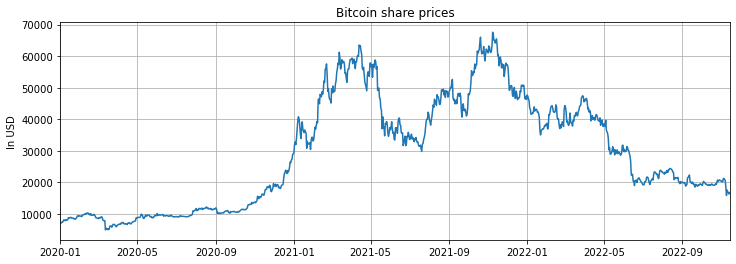

In [9]:
plt.figure(figsize=(12,4))
plt.title('Bitcoin share prices')
plt.ylabel('In USD')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Close'])
plt.show()

## Prepare the data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [10]:
# Extract values from the source .csv file
y = df['Close'].values.astype(float)

# Define a test size
test_size = 30

# Create train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [11]:
test_set

array([19268.09375 , 19550.757813, 19334.416016, 19139.535156,
       19053.740234, 19172.46875 , 19208.189453, 19567.007813,
       19345.572266, 20095.857422, 20770.441406, 20285.835938,
       20595.351563, 20818.476563, 20635.603516, 20495.773438,
       20485.273438, 20159.503906, 20209.988281, 21147.230469,
       21282.691406, 20926.486328, 20602.816406, 18541.271484,
       15880.780273, 17586.771484, 17034.292969, 16799.185547,
       16353.365234, 16777.537109])

## Normalize the data
The formula for normalizing data around zero is:<br>
### $X_{norm} = \frac{X - \mu} {\sigma}$
where $\mu$ is the population mean, and $\sigma$ is the population standard deviation.<br>
Recall that back in the CNN section we transformed image files using <a href='https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize'><tt><strong>torchvision.transforms.Normalize(<em>mean, std</em>)</strong></tt></a>, both because it was built into DataLoader, and because our pretrained models expected specific normalization values.<br>

Ultimately we want to perform <a href='https://en.wikipedia.org/wiki/Feature_scaling'>min/max feature scaling</a> so that our values fall between -1 and 1, as this makes hyperparameters converge faster.<br>The formula for this would be:<br>
### $X^{\prime} = a + \frac{(X - X_{min}) (b - a)} {X_{max} - X_{min}}$
where $a={-1}$ and $b=1$<br>

We can use scikit-learn to do this, with <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html'><tt><strong>sklearn.preprocessing.MinMaxScaler()</strong></tt></a>

NOTE: We only want to normalize the training set to avoid data leakage. If we include the test set then the higher average values of the test set could become part of the signal in the training set. There's a good article on data leakage <a href='test_set = input_data(test_norm,window_size)'>here</a>.

After using transformed data to train the model and generate predictions, we'll inverse_transform the predicted values so that we can compare them to the actual test data.

In [33]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

In [34]:
# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [35]:
train_norm.min()

-0.9999999999999999

In [36]:
train_norm.max()

1.0

In [37]:
train_norm.mean()

-0.20862027171036934

In [38]:
type(train_norm)

numpy.ndarray

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [39]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 7

# Define function to create seq/label tuples
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm,window_size)
len(train_data)  # this should equal 1049-30-30

1012

In [40]:
# Display the first seq/label tuple in the train data
train_data[0]

(tensor([-0.9288, -0.9356, -0.9241, -0.9220, -0.9220, -0.9106, -0.8980]),
 tensor([-0.9007]))

## Define the model
This time we'll use an LSTM layer of size (1,100).

In [64]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=150,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers=2)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(2,1,self.hidden_size),
                       torch.zeros(2,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)

        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions


In [65]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 150, num_layers=2)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)

In [66]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   600
 90000
   600
   600
 90000
 90000
   600
   600
   150
     1
______
273151


In [67]:
## Train the model

In [68]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(2,1,model.hidden_size),
                        torch.zeros(2,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.19761178
Epoch:  2 Loss: 0.18634000
Epoch:  3 Loss: 0.17737721
Epoch:  4 Loss: 0.16527349
Epoch:  5 Loss: 0.14805096
Epoch:  6 Loss: 0.12373843
Epoch:  7 Loss: 0.09185147
Epoch:  8 Loss: 0.05680741
Epoch:  9 Loss: 0.02809045
Epoch: 10 Loss: 0.01146567
Epoch: 11 Loss: 0.00423363
Epoch: 12 Loss: 0.00154733
Epoch: 13 Loss: 0.00059652
Epoch: 14 Loss: 0.00025406
Epoch: 15 Loss: 0.00012390
Epoch: 16 Loss: 0.00007062
Epoch: 17 Loss: 0.00004696
Epoch: 18 Loss: 0.00003562
Epoch: 19 Loss: 0.00002982
Epoch: 20 Loss: 0.00002671
Epoch: 21 Loss: 0.00002496
Epoch: 22 Loss: 0.00002395
Epoch: 23 Loss: 0.00002334
Epoch: 24 Loss: 0.00002295
Epoch: 25 Loss: 0.00002268
Epoch: 26 Loss: 0.00002249
Epoch: 27 Loss: 0.00002233
Epoch: 28 Loss: 0.00002220
Epoch: 29 Loss: 0.00002208
Epoch: 30 Loss: 0.00002198
Epoch: 31 Loss: 0.00002187
Epoch: 32 Loss: 0.00002178
Epoch: 33 Loss: 0.00002168
Epoch: 34 Loss: 0.00002159
Epoch: 35 Loss: 0.00002150
Epoch: 36 Loss: 0.00002141
Epoch: 37 Loss: 0.00002132
E

## Run predictions and compare to known test set


In [46]:
future = 30

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(2,1,model.hidden_size),
                        torch.zeros(2,1,model.hidden_size))
        preds.append(model(seq).item())

In [47]:
# Display predicted values
preds[window_size:]    # equivalent to preds[-future:]

[-0.5488561391830444,
 -0.5500268340110779,
 -0.5506595373153687,
 -0.5512256622314453,
 -0.5520607233047485,
 -0.553324818611145,
 -0.5542025566101074,
 -0.5549201965332031,
 -0.5557461977005005,
 -0.5565427541732788,
 -0.5573426485061646,
 -0.5581462383270264,
 -0.5589364171028137,
 -0.5596897602081299,
 -0.5604315996170044,
 -0.5611690878868103,
 -0.561893880367279,
 -0.5626071691513062,
 -0.5633084774017334,
 -0.5639967918395996,
 -0.5646727681159973,
 -0.5653378367424011,
 -0.5659919381141663,
 -0.5666347742080688,
 -0.5672665238380432,
 -0.5678873658180237,
 -0.5684974193572998,
 -0.5690968632698059,
 -0.5696859359741211,
 -0.5702648162841797]

In [48]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[19090.69767352],
       [19054.05724336],
       [19034.25488267],
       [19016.53629372],
       [18990.40053553],
       [18950.83685532],
       [18923.36539386],
       [18900.90468518],
       [18875.05248411],
       [18850.12184368],
       [18825.08673483],
       [18799.93596453],
       [18775.20493339],
       [18751.6267858 ],
       [18728.40868113],
       [18705.32675849],
       [18682.64218893],
       [18660.31766229],
       [18638.36810263],
       [18616.82522357],
       [18595.66850454],
       [18574.85317336],
       [18554.38109553],
       [18534.26159859],
       [18514.48908602],
       [18495.05796131],
       [18475.96449342],
       [18457.20308585],
       [18438.76627655],
       [18420.64846902]])

In [49]:
# Remember that the stop date has to be later than the last predicted value.
x = np.arange('2022-10-16', '2022-11-15', dtype='datetime64[D]').astype('datetime64[D]')
x

array(['2022-10-16', '2022-10-17', '2022-10-18', '2022-10-19',
       '2022-10-20', '2022-10-21', '2022-10-22', '2022-10-23',
       '2022-10-24', '2022-10-25', '2022-10-26', '2022-10-27',
       '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31',
       '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
       '2022-11-05', '2022-11-06', '2022-11-07', '2022-11-08',
       '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-12',
       '2022-11-13', '2022-11-14'], dtype='datetime64[D]')

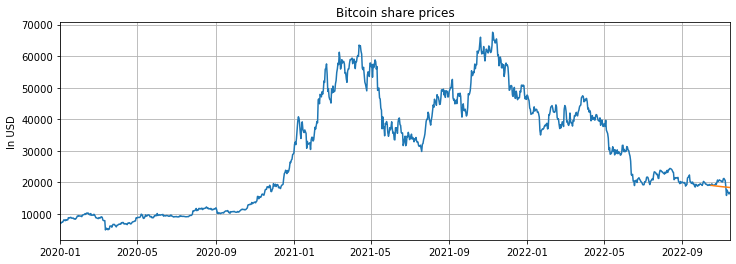

In [50]:
plt.figure(figsize=(12,4))
plt.title('Bitcoin share prices')
plt.ylabel('In USD')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['Close'])
plt.plot(x,true_predictions)
plt.show()

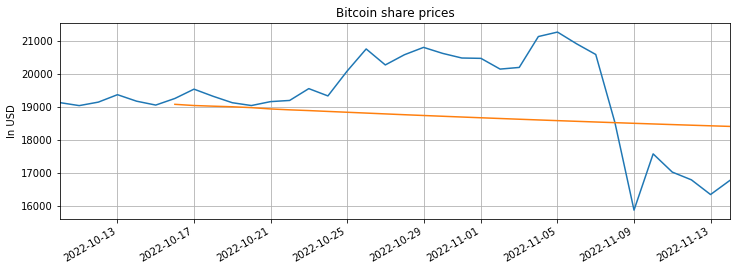

In [51]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Bitcoin share prices')
plt.ylabel('In USD')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['Close']['2022-10-10':])
plt.plot(x,true_predictions)
plt.show()

In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
np.sqrt(mean_squared_error(test_set.reshape(len(test_set)), true_predictions.reshape(len(true_predictions))))

1571.7160894588947